# Geneformer gene embeddings extraction and building a gene co-expression/regulation network (GRN)
Here we show how to extract gene embeddings from the pre-trained Geneformer 10M model, and how to build a gene co-expression network from gene embeddings for selected genes.

The single cell sequencing data set is from CellxGene, the same as used in the [cell type annotation tutorial](geneformer-celltype-classification.ipynb). The gene co-expression network is adapted from a [scGPT tutorial](https://scgpt.readthedocs.io/en/latest/tutorial_grn.html).

First, we download the dataset from czi that we are interested in, and then create the requisite sc_memmap dataset object. Then we extract gene embeddings using infer_geneformer. After that, we can get the gene embedding values to build gene co-expression network based on cosine similarity.

In [1]:
# NBVAL_CHECK_OUTPUT
import cellxgene_census


CENSUS_VERSION = "2023-12-15"
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    adata = cellxgene_census.get_anndata(
        census,
        "Homo sapiens",
        obs_value_filter='dataset_id=="8e47ed12-c658-4252-b126-381df8d52a3d"',
    )
uq_cells = sorted(adata.obs["cell_type"].unique().tolist())
uq_cells

/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


['B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'IgA plasma cell',
 'IgG plasma cell',
 'M cell of gut',
 'T follicular helper cell',
 'activated CD4-positive, alpha-beta T cell, human',
 'conventional dendritic cell',
 'dendritic cell, human',
 'endothelial cell of artery',
 'endothelial cell of lymphatic vessel',
 'enterocyte',
 'enteroendocrine cell',
 'fibroblast',
 'gamma-delta T cell',
 'glial cell',
 'intestinal crypt stem cell',
 'intestinal tuft cell',
 'intestine goblet cell',
 'mast cell',
 'memory B cell',
 'monocyte',
 'myeloid cell',
 'myofibroblast cell',
 'pericyte',
 'plasma cell',
 'plasmacytoid dendritic cell',
 'regulatory T cell',
 'transit amplifying cell',
 'vein endothelial cell']

In [2]:
# NBVAL_CHECK_OUTPUT
import random
from contextlib import contextmanager


@contextmanager
def random_seed(seed: int):
    """Context manager to set the random seed for reproducibility."""
    state = random.getstate()
    random.seed(seed)
    try:
        yield
    finally:
        # Go back to previous state
        random.setstate(state)


with random_seed(32):
    indices = list(range(len(adata)))
    random.shuffle(indices)

micro_batch_size: int = 32
num_steps: int = 256
selection = sorted(indices[: micro_batch_size * num_steps])
# NOTE: there's a current constraint that predict_step needs to be a function of micro-batch-size.
#  this is something we are working on fixing. A quick hack is to set micro-batch-size=1, but this is
#  slow. In this notebook we are going to use mbs=32 and subsample the anndata.
adata = adata[selection].copy()  # so it's not a view
adata.shape

(8192, 60664)

In [3]:
import shutil

from bionemo.core import BIONEMO_CACHE_DIR


cleanup: bool = True
notebook_workdir = BIONEMO_CACHE_DIR / "notebook_tutorials" / "geneformer_geneembeddings-GRN"
if cleanup and notebook_workdir.exists():
    shutil.rmtree(notebook_workdir)
notebook_workdir.mkdir(parents=True, exist_ok=True)
input_dir = notebook_workdir / "celltype-bench-dataset-input"
data_dir = notebook_workdir / "celltype-bench-dataset"
input_dir.mkdir(parents=True, exist_ok=True)
h5ad_outfile = input_dir / "hs-celltype-bench.h5ad"
adata.write_h5ad(h5ad_outfile)

Your results are saved in this directory.

In [4]:
print(notebook_workdir)

/root/.cache/bionemo/notebook_tutorials/geneformer_geneembeddings-GRN


## Create the scmemmap object, check outputs

In [5]:
!convert_h5ad_to_scdl --data-path {input_dir} --save-path {data_dir}

Importantly, the `.npy` files are used by BioNeMo dataset object. `features.csv` contains the metadata requested, in this case cell_type. It's important that the output of our model has the same order as `features.csv`, as this contains the labels used in the following benchmark.

In [6]:
# NBVAL_CHECK_OUTPUT
from glob import glob


files = sorted(
    [f.split("/")[-1] for f in glob(str(data_dir / "*"))]
)  # strip off the directory name and sort for the test
files

['col_ptr.npy',
 'data.npy',
 'features',
 'metadata.json',
 'row_ptr.npy',
 'version.json']

Import geneformer-10M model for infer geneformer to retrieve gene embeddings

In [7]:
from bionemo.core.data.load import load

# 10m checkpoint
geneformer_10m = load("geneformer/10M_240530:2.0")


In [8]:
result_path_10m = notebook_workdir / "results_10m.pt"

## Execute inference
We run inference on the Geneformer model downloaded by `load(...)` function in a previous cell. We have a one-off inference script for geneformer that is installed as part of the `bionemo-geneformer` package. See the `pyproject.toml` in the source directory if you are curious or want to use this as a template to make your own inference scripts. This script should work for any `sc_memmap` converted geneformer dataset, and geneformer bionemo2 model checkpoint though.

In order to extract gene embeddings, you also need to specify --include-input-ids and --include-hiddens

In [9]:
!infer_geneformer \
    --data-dir {data_dir} \
    --checkpoint-path {geneformer_10m} \
    --results-path {result_path_10m} \
    --micro-batch-size {micro_batch_size} \
    --seq-len 2048 \
    --num-dataset-workers 10 \
    --num-gpus 1 \
    --include-input-ids \
    --include-hiddens \
    --include-gene-embeddings

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:239: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. 

## Load gene embeddings
Load gene embeddings and add gene names. If executed correctly, you should be able to see gene_embeddings in predictions.keys().

In [10]:
import torch

predictions=torch.load(result_path_10m / "predictions__rank_0.pt",weights_only=False)

print(predictions.keys())

dict_keys(['token_logits', 'binary_logits', 'hidden_states', 'input_ids', 'embeddings', 'gene_embeddings'])


In [11]:
##This is where you can find the geneformer.vocab for input_ids

In [12]:
import json
from pathlib import Path

train_data_path: Path = (
    load("single_cell/testdata-20241203") / "cellxgene_2023-12-15_small_processed_scdl" / "train"
)

with open(train_data_path / "geneformer.vocab", "r") as f:
    geneformer_vocab = json.load(f)


Match tokens in gene embeddings to gene symbols

In [13]:
import pandas as pd

# Step 1: Load vocab
id_to_token = {v: k for k, v in geneformer_vocab["vocab"].items()}
ens_to_symbol = {ens: symbol for symbol, ens in geneformer_vocab.get("gene_to_ens", {}).items()}

# Step 2: Convert gene_embeddings dict to DataFrame
gene_embeddings = predictions["gene_embeddings"]

gene_embeddings_rows = []
gene_embeddings_row_names = []

for token_id, emb_tensor in gene_embeddings.items():
    if token_id in {0, 1, 2, 3, 4}:  # Skip [CLS], [MASK], [PAD], [SEP], [UKW]
        continue
    token = id_to_token.get(token_id, f"UNKNOWN_{token_id}")
    gene_symbol = ens_to_symbol.get(token, token) if token.startswith("ENSG") else token
    gene_embeddings_rows.append(emb_tensor.to(torch.float32).cpu().numpy())
    gene_embeddings_row_names.append(gene_symbol)

# Step 3: Create DataFrame
gene_embeddings_df = pd.DataFrame(gene_embeddings_rows, index=gene_embeddings_row_names)

gene_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
NBEAL1,0.042725,0.167969,-0.044922,-0.062012,-0.091309,0.021484,0.083984,-0.083984,0.047607,0.167969,...,0.076660,-0.086426,-0.014343,0.167969,0.083984,-0.047852,-0.128906,0.083984,-0.084473,-0.146484
RPL39,0.066406,-0.132812,-0.033203,-0.033203,0.132812,0.066406,-0.066406,0.037354,0.066406,-0.066406,...,0.066406,-0.053955,0.033203,-0.016602,-0.034912,0.016602,-0.066406,0.034180,0.033203,0.033936
RPS27,0.104980,-0.127930,0.053955,0.063965,-0.029175,0.063965,0.018799,-0.066406,0.063965,-0.063965,...,-0.063965,0.104980,0.063965,0.034912,-0.046631,-0.032471,-0.084473,0.016479,-0.032227,0.032471
ZNF90,0.283203,0.281250,-0.071289,0.015320,-0.255859,-0.141602,0.092285,-0.143555,0.081543,0.265625,...,0.141602,0.141602,0.141602,0.143555,-0.102051,-0.071777,-0.153320,-0.141602,-0.070801,-0.141602
RPS29,0.055908,-0.125977,0.030884,-0.041260,0.032227,0.062988,-0.062988,-0.062988,-0.031494,0.062988,...,-0.062988,-0.056396,0.037842,0.062988,0.062988,-0.031494,-0.067871,-0.032227,-0.040527,-0.062988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGKV3D-7,1.140625,-0.300781,0.176758,-0.291016,-0.316406,-0.781250,1.062500,-0.002213,0.671875,1.132812,...,-0.142578,0.005066,-0.546875,0.921875,0.205078,-0.089844,-1.679688,-0.014648,0.287109,0.113770
FAM187B,-0.050293,-0.765625,0.024658,0.020020,-0.562500,1.203125,0.057617,0.478516,0.523438,1.984375,...,-0.902344,0.093750,1.281250,0.976562,0.855469,-0.593750,1.304688,0.281250,-0.230469,-0.176758
ATP2B3,0.843750,-0.359375,-0.425781,0.785156,-0.187500,-0.470703,0.171875,0.006409,0.205078,2.203125,...,-1.289062,-0.238281,0.022095,1.070312,0.500000,-0.398438,1.187500,1.390625,-0.625000,0.186523
ITIH1,0.058594,-1.812500,-0.380859,0.018555,-0.957031,0.503906,0.074219,0.718750,0.333984,2.421875,...,-0.353516,-0.425781,0.359375,1.093750,0.769531,-0.126953,0.796875,1.570312,-0.070312,0.671875


## Visualize network connectivity within desired gene program

The following tutorial is adapted from scGPT tutorial to show how to use gene embeddings to build gene co-expression network

In [14]:
CD_genes=['LCK', 'CD2', 'LTB', 'CD3E', 'CD3G', 'CD8B', 'CD8A', 'IL7R', 'CD3D']

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import operator

def compute_similarities(gene_embeddings_df,gene, subset=None):
    """
    Compute cosine similarities of the given gene against all others
    in the `gene_embeddings_df` DataFrame.
    
    Parameters:
    - gene (str): Gene symbol to compare against.
    - subset (list[str], optional): Optional list of target genes to compare to.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Gene', 'Similarity'] sorted by similarity.
    """
    if gene not in gene_embeddings_df.index:
        return None

    embedding = gene_embeddings_df.loc[gene].values.reshape(1, -1)
    
    if subset:
        targets = list(set(gene_embeddings_df.index).intersection(set(subset)))
    else:
        targets = list(gene_embeddings_df.index)

    similarities = {}
    for target in targets:
        if target == gene:
            continue
        v = gene_embeddings_df.loc[target].values.reshape(1, -1)
        similarity = float(cosine_similarity(embedding, v)[0])
        similarities[target] = similarity

    # Sort by similarity (descending)
    sorted_distances = sorted(similarities.items(), key=operator.itemgetter(1), reverse=True)

    return pd.DataFrame(sorted_distances, columns=["Gene", "Similarity"])


In [16]:
import tqdm

# Initialize an empty list to collect DataFrames
df_list = []

gene_embeddings_df_CD = gene_embeddings_df.loc[gene_embeddings_df.index.intersection(CD_genes)]

for i in tqdm.tqdm(CD_genes):
    df = compute_similarities(gene_embeddings_df_CD,i)
    if df is not None:
        df['Gene1'] = i
        df_list.append(df)

# Concatenate all collected DataFrames
df_CD = pd.concat(df_list, ignore_index=True)

# Filter out self-similarity and sort
df_CD_sub = df_CD[df_CD['Similarity'] < 0.99].sort_values(by='Gene')

df_CD_sub

/tmp/ipykernel_2154/463890092.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarity = float(cosine_similarity(embedding, v)[0])
/tmp/ipykernel_2154/463890092.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarity = float(cosine_similarity(embedding, v)[0])
/tmp/ipykernel_2154/463890092.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarity = float(cosine_similarity(embedding, v)[0])
/tmp/ipykernel_2154/463890092.py:33: DeprecationWarning

,Gene,Similarity,Gene1
22,CD2,0.460596,LTB
46,CD2,0.516001,CD8B
31,CD2,0.494635,CD3E
62,CD2,0.486120,IL7R
39,CD2,0.316087,CD3G
...,...,...,...
54,LTB,0.516336,CD8A
45,LTB,0.573031,CD8B
38,LTB,0.371290,CD3G
61,LTB,0.542687,IL7R


In [17]:
import networkx as nx
import matplotlib.pyplot as plt

In [18]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

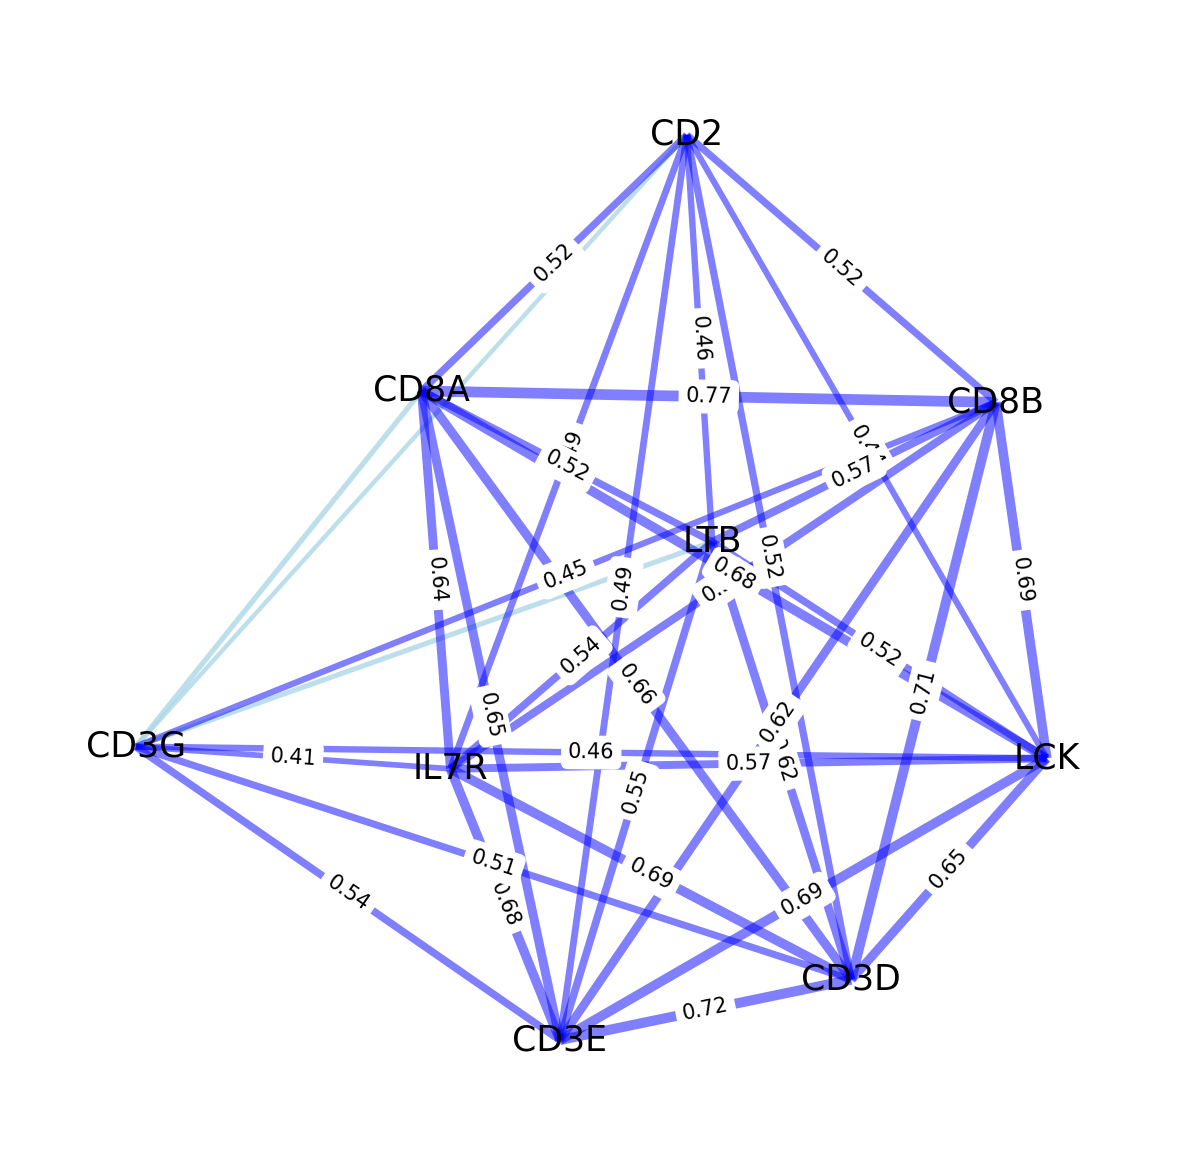

In [19]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.4
plt.figure(figsize=(15, 15))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > thresh:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos,
                       edgelist = width_large.keys(),
                       width = list(width_large.values()),
                       alpha = 0.5,
                       edge_color = "blue",
                      )
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.show()